# Phase Retrieval in dLux

In this notebook, we will go through a simple example of phase retrieval in dLux, just recovering Zernike coefficients for an aberrated circular aperture by gradient descent.

First, we import the necessary packages, including `Jax`:

In [1]:
# Core jax
import jax
import jax.numpy as np
import jax.random as jr

# Optimisation
import zodiax as zdx
import optax

# Optics
import dLux as dl

# Plotting/visualisation
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

dLux: Jax is running in 32-bit, to enable 64-bit visit: https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision


Now, we want to construct a basic optical system with a 1m aperture. 

We also generate a Zernike basis in order to model some optical aberrations, omitting the piston/tip/tilt elements, and initialising them as normally-distributed coefficients over that basis. 

As noted by [Martinache et al 2013](https://ui.adsabs.harvard.edu/abs/2013PASP..125..422M/abstract), you can only detect the sign of even-order aberrations if your pupil is not inversion-symmetric; so following that paper, we introduce a small bar asymmetry.

In [2]:
# Basic Optical Parameters
diameter = 1.
wf_npix = 256 

# Detector Parameters
det_npix = 256 
det_pixsize = dl.utils.arcseconds_to_radians(1e-2)

# Generate an asymmetry
c, s = wf_npix//2, 13
asymmetry = np.ones((wf_npix,wf_npix)).at[c-s:c+s, :c].set(0)
asymmetric_mask = dl.TransmissiveOptic(asymmetry)

# Define the aberrations
seed = 0
zernikes = np.arange(4, 11)
coeffs = 2e-8*jr.normal(jr.PRNGKey(seed), (len(zernikes),))

Here is the core syntax of `dLux`: a list of optical layers. Unlike some other systems, we are *very* explicit about the whole optical system: 

- First initialize a wavefront using the `CreateWavefront` class. 
- For a simple circular aperutre extending the width of the wavefront we use the `ApertureFactory` class, specifying the the properties we want (ratio of primary to secondary mirror, number of struts etc), so it can pre-calculate the aperture and return the correct aperture class.
- We then want to apply the zernike aberrations using `AberrationFactory` to generate this class for us.
- To introduce our assymetry we add a `TransmissiveOptic` layer, feeding in the asymmetric array on ones and zeros we calcualted.
- We then normalise the flux to unitary power *after* the wavefront has passed through these two layers.
- Then we propagate our wavefront to a focal plane using the `AngularMFT` class, which defines pixel scale units in angular SI units, ie radians, specifying the number of pixels in the output detector.

In [3]:
# Define Optical Configuration
optical_layers = [
    dl.CreateWavefront(wf_npix, diameter),
    dl.ApertureFactory(wf_npix, nstruts=3, secondary_ratio=0.1, strut_ratio=0.01, name='Aperture'),
    dl.AberrationFactory(wf_npix, zernikes=zernikes, coefficients=coeffs, name='Aberrations'),
    dl.TransmissiveOptic(asymmetry),
    dl.NormaliseWavefront(),
    dl.AngularMFT(det_npix, det_pixsize)]

Now we also need to create a source that we will be examining with this optical configuration. Here we use a simple point source, which is initialised on-axis, with a flux of one. We only need to define the wavelengths of this source, so lets have a look at the resulting object.

In [4]:
# Create a point source
wavels = np.linspace(450e-9, 550e-9, 5)
source = dl.PointSource(wavelengths=wavels)

Now we want to combine these two objects together into the convenient dLux.Instrument class, in order to model the optical system response to the point source.

Note all dLux objects that contain 'layers' - such as the optical layers we define above - can be accessed like an attribute of the class. In this case we want to examine the input optical aberrations, so we will access the 'ApplyBasisOPD' layer using this method.

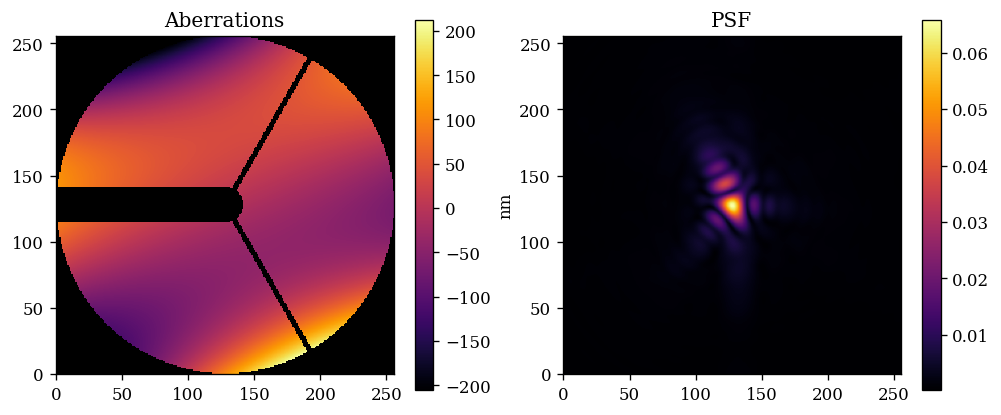

In [5]:
# Construct the instrument with the source
telescope = dl.Instrument(optical_layers=optical_layers, sources=[source])

# Get aperture & aberrations
aper_in = telescope.Aperture.get_aperture()
aberr_in = telescope.Aberrations.get_opd()

# Get mask, setting nan values for visualisation
mask = 1.0*(aper_in*asymmetry > 1e-5)
mask = mask.at[mask==False].set(np.nan)
cmap = colormaps['inferno']
cmap.set_bad('k',1.)

# Model the PSF using the .model() method
psf = telescope.model()

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Aberrations")
plt.imshow(mask*aberr_in*1e9, cmap=cmap)
plt.colorbar(label='nm')

plt.subplot(1, 2, 2)
plt.title("PSF")
plt.imshow(psf**0.5)
plt.colorbar()
plt.show()

Excellent! Now we want to try and recover these aberrations. To do this we want to create a new optical system with a *different* set of zernike aberrations. We can do this using the `.set()` method and defining the path the optical aberration coefficients and assigning a newly-randomlised coefficient values. With this new optical system we will try and recover the original aberration coefficients using gradient descent methods.

In [6]:
# Define path to the zernikes
zernikes = 'Aberrations.coefficients'

# Generate new random set of zernikes
coeffs_init = 2e-8*jr.normal(jr.PRNGKey(seed + 1), [len(coeffs)])

# Generate a new model with updated zernike coefficients
model = telescope.set(zernikes, coeffs_init)

Now we need to define our loss function, and specify that we want to optimise the zernike coefficients. To do this we can pass in the string path to our zernikes that we just defined into the `zdx.filter_value_and_grad()` function. Note we also use the `zdx.filter_jit()` function in order to compile this function into XLA in order to run much faster!

In [7]:
@zdx.filter_jit
@zdx.filter_value_and_grad(zernikes)
def loss_func(model, data):
    out = model.model()
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

Now we compile the function and time its evaluation - even on CPU it is fast!

In [8]:
%%time
loss, initial_grads = loss_func(model, psf) # Compile
print("Initial Loss: {}".format(loss))

Initial Loss: 8.380279541015625
CPU times: user 1.78 s, sys: 30.7 ms, total: 1.81 s
Wall time: 551 ms


In [9]:
%%timeit
loss = loss_func(model, psf)[0].block_until_ready()

1.45 ms ± 39.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Now begin the optimization loop using `optax` with a low learning rate. 

In [10]:
optim, opt_state = model.get_optimiser([zernikes], [optax.adam(2e-9)])

losses, models_out = [], []
with tqdm(range(100),desc='Gradient Descent') as t:
    for i in t: 
        # calculate the loss and gradient
        loss, grads = loss_func(model, psf) 
        
        # apply the update
        updates, opt_state = optim.update(grads, opt_state)
        model = model.apply_updates(updates)
        
        # save results
        models_out.append(model) 
        losses.append(loss)
        
        t.set_description('Loss %.5f' % (loss)) # update the progress bar
final_psf = model.model(source=source)

Gradient Descent:   0%|          | 0/100 [00:00<?, ?it/s]

Now we visualize this: we have great performance, recovering the input Zernike coefficients accurately and a beautiful PSF recovery.

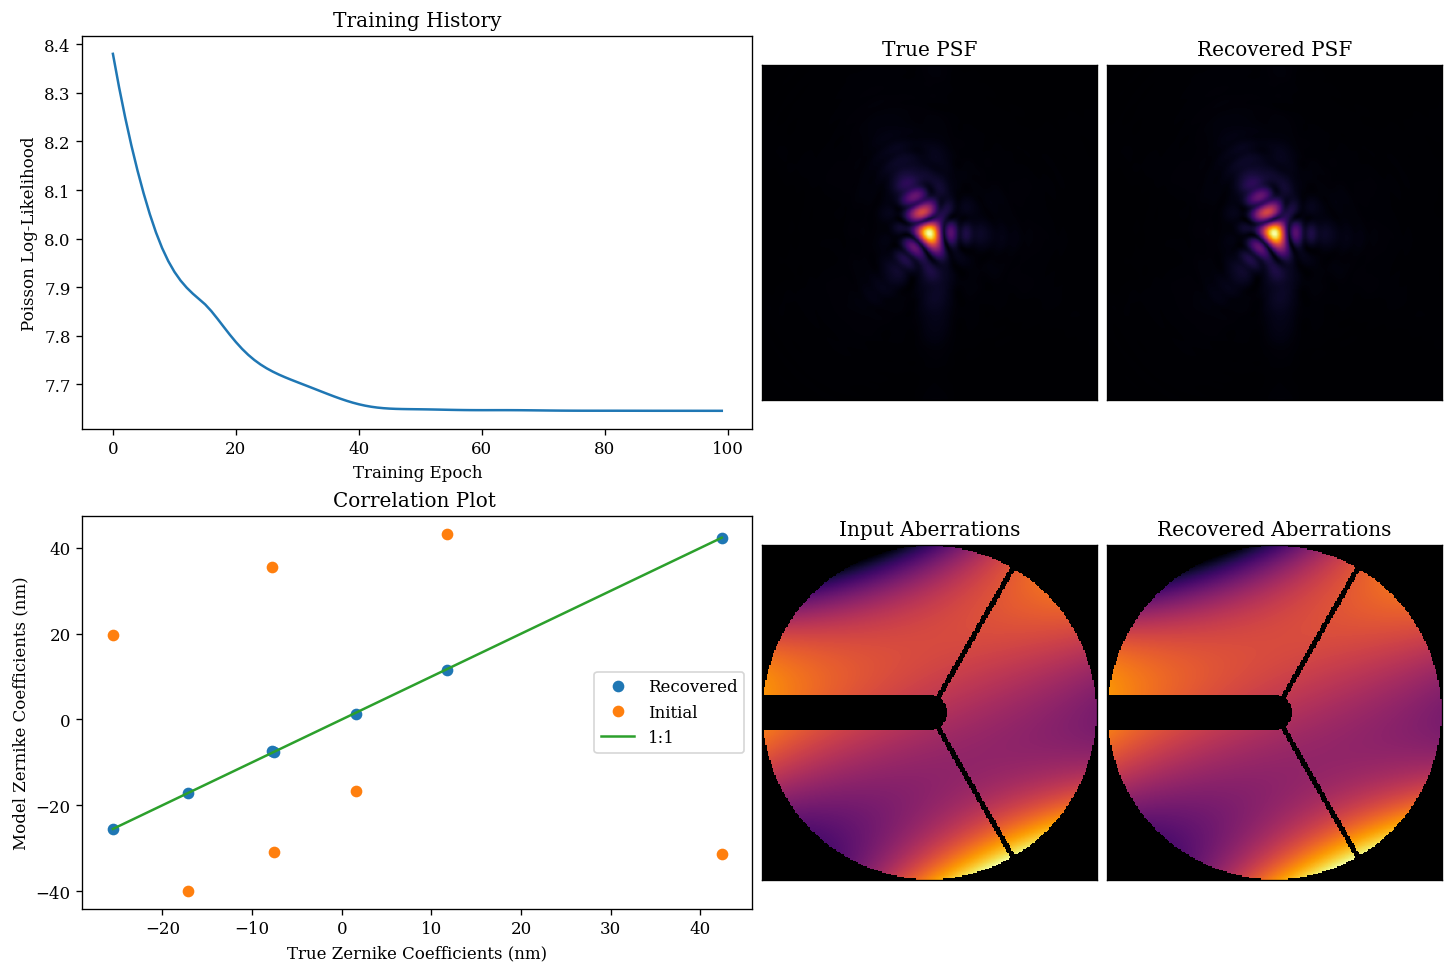

In [11]:
coeffs_out = np.array([model_out.get(zernikes) for model_out in models_out])

mosaic = """
    AABD
    GGEF
    """

fig = plt.figure(constrained_layout=True,figsize=(12, 8))
axes = fig.subplot_mosaic(mosaic)

for ax in ['B','D','E','F']:
    axes[ax].set_xticks([])
    axes[ax].set_yticks([])

axes['A'].plot(np.array(losses))
axes['A'].set_title("Training History")
axes['A'].set_xlabel('Training Epoch')
axes['A'].set_ylabel('Poisson Log-Likelihood')

axes['B'].imshow(psf**0.5)
axes['B'].set_title('True PSF')

axes['G'].plot(coeffs*1e9,model.get(zernikes)*1e9,'.',markersize=12,color='C0',label='Recovered')
axes['G'].plot(coeffs*1e9,coeffs_init*1e9,'.',markersize=12,color='C1',label='Initial')

axes['G'].plot(np.array([np.min(coeffs),np.max(coeffs)])*1e9,
               np.array([np.min(coeffs),np.max(coeffs)])*1e9,
               '-',color='C2',label='1:1')
axes['G'].legend()
axes['G'].set_title('Correlation Plot ')
axes['G'].set_xlabel('True Zernike Coefficients (nm)')
axes['G'].set_ylabel('Model Zernike Coefficients (nm)')

axes['D'].imshow(final_psf**0.5)
axes['D'].set_title('Recovered PSF')

axes['E'].imshow(mask*aberr_in, cmap=cmap)
axes['E'].set_title('Input Aberrations')

axes['F'].imshow(mask*model.Aberrations.get_opd(), cmap=cmap)
axes['F'].set_title('Recovered Aberrations')
plt.show()